In [1]:
!pip install pygame
!pip install gym==0.26.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordEpisodeStatistics
gymlogger.set_level(40) #error only
from torch import nn
import torch
from torch.nn import functional as F
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from base64 import b64encode

from IPython import display as ipythondisplay
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
gym.__version__

'0.26.2'

In [4]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

In [5]:
class QLearningTable:
  def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.1):
    self.actions = actions
    self.lr = learning_rate
    self.gamma = reward_decay
    self.epsilon = e_greedy
    self.q_table = pd.DataFrame(columns = self.actions, dtype=np.float64)

  def choose_action(self, observation, action_mask, is_test):
    self.check_state_exist(observation)


    if np.random.uniform()>self.epsilon or is_test==True:
      state_action = self.q_table.loc[observation, :]
      state_action = state_action[action_mask==1]
      action = np.random.choice(state_action[state_action == np.max(state_action)].index)
    else:
      action = np.random.choice(self.actions)
    return action

  def learn(self, s, a, r, s_, terminal):
    self.check_state_exist(s_)
    q_predict = self.q_table.loc[s, a]
    if terminal:
      q_target = r
    else:
      q_target = r+self.gamma*self.q_table.loc[s_, :].max()
    self.q_table.loc[s, a] += self.lr*(q_target-q_predict)
    # print(self.q_table.loc[s, a])



  def check_state_exist(self, state):
    # print(self.q_table)
    if state not in self.q_table.index:
      self.q_table.loc[state] = [0]*len(self.actions)

In [24]:
RL = QLearningTable(range(6), learning_rate=0.5)

In [28]:
observation, info = env.reset()
print(info['action_mask'])

[1 1 0 1 0 0]


In [29]:
#train
cost_list = []
total_episode = 1000
for episode in range(total_episode):
  RL.epsilon = (1-episode/total_episode)
  observation, infos = env.reset()
  taxi_row, taxi_col, passenger_location, destination = env.decode(observation)
  start_passenger_location = passenger_location
  start_destination = destination
  cost = 0
  while True:
    env.render()
    if passenger_location!=4 and taxi_row==env.locs[passenger_location][0] and taxi_col==env.locs[passenger_location][1]:
      action = 4
    elif passenger_location==4 and taxi_row==env.locs[destination][0] and taxi_col==env.locs[destination][1]:
      action = 5
    else:
      mask = infos['action_mask']
      mask[4] = 0
      mask[5] = 0
      action = RL.choose_action(observation, infos['action_mask'], False)
    observation_, rewards, terminated, truncated, infos = env.step(action)
    RL.learn(observation, action, rewards, observation_, terminated)
    observation = observation_
    taxi_row, taxi_col, passenger_location, destination = env.decode(observation)
    cost+=rewards
    # print(terminated, cost, rewards, [taxi_row, taxi_col], env.locs[destination], passenger_location)
    # print(RL.q_table)
    if terminated:
      cost_list.append([[start_passenger_location, start_destination], cost])
      break
  if(episode+1)%10==0:
    print(f'{episode+1}episode has finish.')
    print(cost_list)

10episode has finish.
[[[1, 3], -2565], [[1, 0], -1449], [[3, 2], -1075], [[3, 2], -8426], [[0, 1], -175], [[1, 2], -2467], [[0, 1], -971], [[3, 1], -1442], [[1, 3], -543], [[1, 0], -452]]
20episode has finish.
[[[1, 3], -2565], [[1, 0], -1449], [[3, 2], -1075], [[3, 2], -8426], [[0, 1], -175], [[1, 2], -2467], [[0, 1], -971], [[3, 1], -1442], [[1, 3], -543], [[1, 0], -452], [[1, 2], -698], [[1, 2], -4149], [[0, 2], -1608], [[0, 2], -3205], [[3, 2], -1465], [[2, 1], -2743], [[1, 0], -850], [[1, 3], -323], [[1, 3], -1304], [[3, 0], -1333]]
30episode has finish.
[[[1, 3], -2565], [[1, 0], -1449], [[3, 2], -1075], [[3, 2], -8426], [[0, 1], -175], [[1, 2], -2467], [[0, 1], -971], [[3, 1], -1442], [[1, 3], -543], [[1, 0], -452], [[1, 2], -698], [[1, 2], -4149], [[0, 2], -1608], [[0, 2], -3205], [[3, 2], -1465], [[2, 1], -2743], [[1, 0], -850], [[1, 3], -323], [[1, 3], -1304], [[3, 0], -1333], [[2, 1], -659], [[3, 0], -3442], [[1, 0], -505], [[1, 3], -544], [[1, 2], -2066], [[3, 0], -1935], 

In [30]:
def draw_pic(x, y, title, index):
  plt.figure(index)
  plt.plot(x, y)
  plt.xlabel("iteration")
  plt.ylabel("cost")
  plt.title(title)

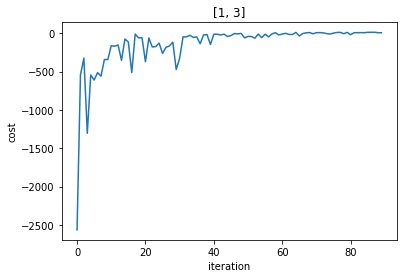

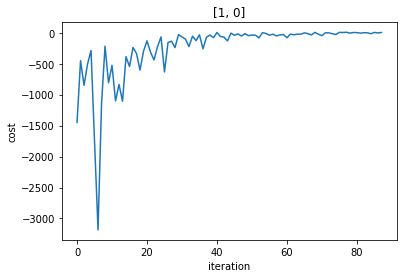

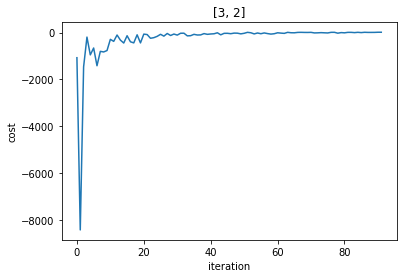

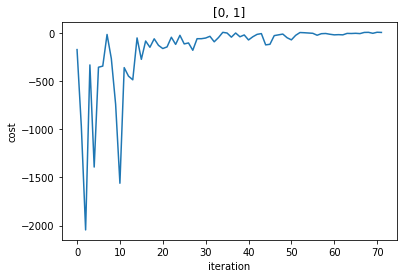

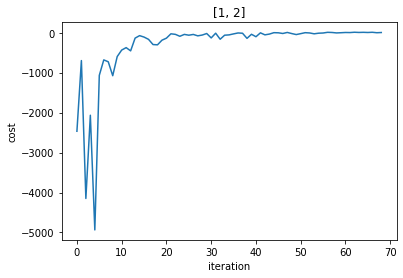

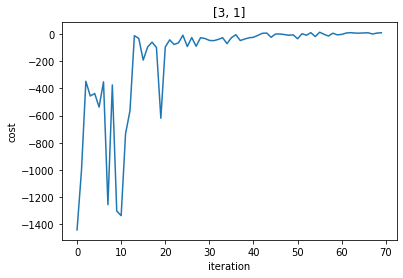

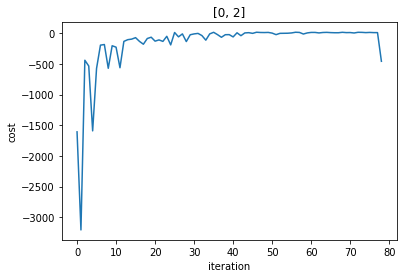

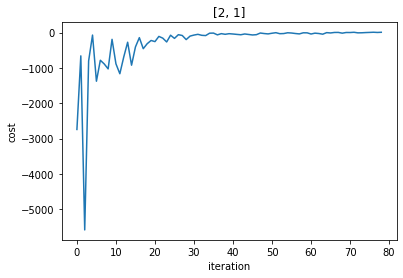

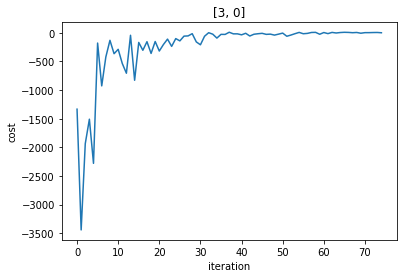

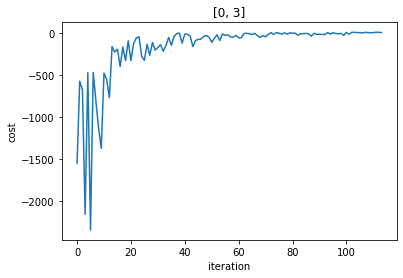

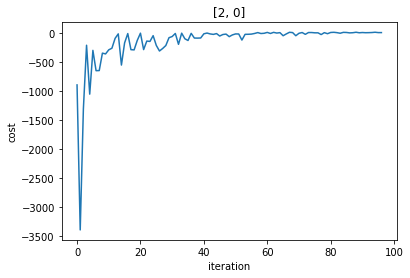

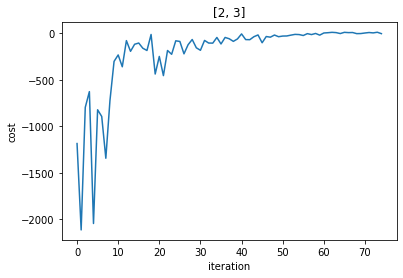

In [31]:
#draw graph
value_dict = {}
distinct_key = []
for i in cost_list:
  if i[0] not in distinct_key:
    distinct_key.append(i[0])
for i in distinct_key:
  value_dict[str(i)] = []
for i in cost_list:
  value_dict[str(i[0])].append(i[1])
for i in range(len(distinct_key)):
  draw_pic(range(len(value_dict[str(distinct_key[i])])), value_dict[str(distinct_key[i])], distinct_key[i], i)

In [32]:
#test
test_cost_list = []
test_total_episode = 1000
failure_times = 0
for episode in range(test_total_episode):
  observation, infos = env.reset()
  taxi_row, taxi_col, passenger_location, destination = env.decode(observation)
  start_passenger_location = passenger_location
  start_destination = destination
  cost = 0
  while True:
    env.render()
    if passenger_location!=4 and taxi_row==env.locs[passenger_location][0] and taxi_col==env.locs[passenger_location][1]:
      action = 4
    elif passenger_location==4 and taxi_row==env.locs[destination][0] and taxi_col==env.locs[destination][1]:
      action = 5
    else:
      mask = infos['action_mask']
      mask[4] = 0
      mask[5] = 0
      action = RL.choose_action(observation, infos['action_mask'], True)
    observation_, rewards, terminated, truncated, infos = env.step(action)
    observation = observation_
    taxi_row, taxi_col, passenger_location, destination = env.decode(observation)
    cost+=rewards
    if cost<-100:
      failure_times+=1
      break
    # print(terminated, cost, rewards, [taxi_row, taxi_col], env.locs[destination], passenger_location)
    # print(RL.q_table)
    # print(cost)
    if terminated:
      test_cost_list.append([[start_passenger_location, start_destination], cost])
      break
  if(episode+1)%10==0:
    print(f'{episode+1}episode has finish.')
    print(test_cost_list)

10episode has finish.
[[[1, 2], 5], [[2, 3], 12], [[0, 1], 9], [[0, 2], 9], [[3, 0], 8], [[0, 2], 11], [[1, 3], 12], [[0, 2], 10], [[0, 2], 9], [[2, 0], 15]]
20episode has finish.
[[[1, 2], 5], [[2, 3], 12], [[0, 1], 9], [[0, 2], 9], [[3, 0], 8], [[0, 2], 11], [[1, 3], 12], [[0, 2], 10], [[0, 2], 9], [[2, 0], 15], [[1, 2], 7], [[1, 0], 9], [[1, 2], 4], [[0, 3], 7], [[2, 3], 8], [[2, 0], 10], [[2, 3], 6], [[1, 2], 7], [[0, 2], 11], [[1, 3], 9]]
30episode has finish.
[[[1, 2], 5], [[2, 3], 12], [[0, 1], 9], [[0, 2], 9], [[3, 0], 8], [[0, 2], 11], [[1, 3], 12], [[0, 2], 10], [[0, 2], 9], [[2, 0], 15], [[1, 2], 7], [[1, 0], 9], [[1, 2], 4], [[0, 3], 7], [[2, 3], 8], [[2, 0], 10], [[2, 3], 6], [[1, 2], 7], [[0, 2], 11], [[1, 3], 9], [[2, 3], 8], [[2, 1], 4], [[1, 3], 9], [[1, 2], 7], [[3, 0], 7], [[1, 0], 7], [[2, 1], 7], [[1, 3], 9], [[1, 0], 7], [[0, 1], 8]]
40episode has finish.
[[[1, 2], 5], [[2, 3], 12], [[0, 1], 9], [[0, 2], 9], [[3, 0], 8], [[0, 2], 11], [[1, 3], 12], [[0, 2], 10], [

In [35]:
(1-failure_times/test_total_episode)

0.986

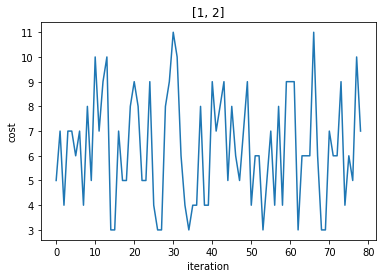

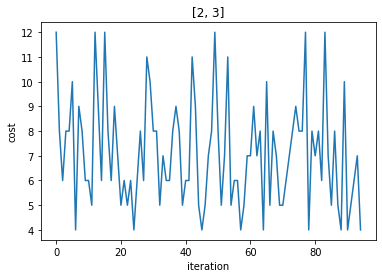

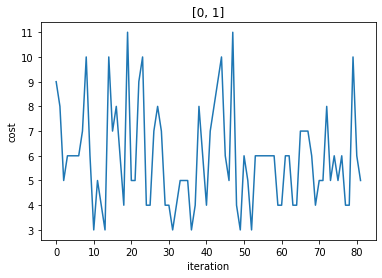

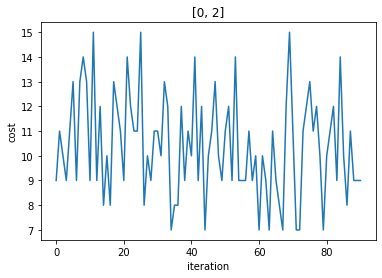

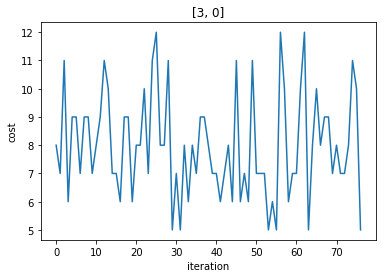

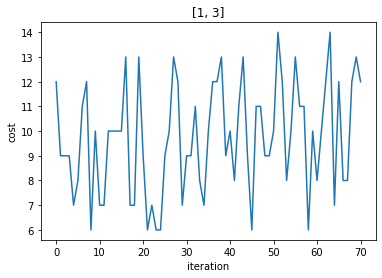

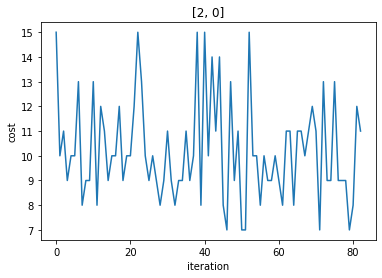

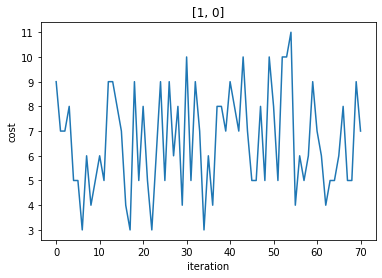

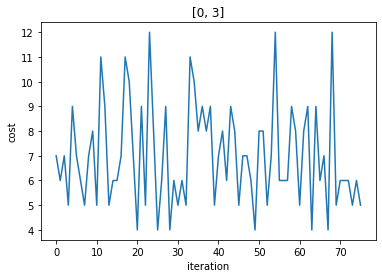

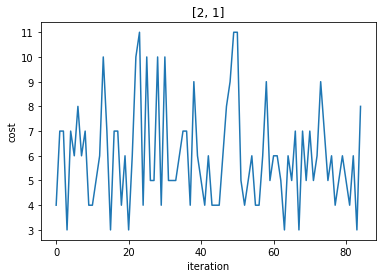

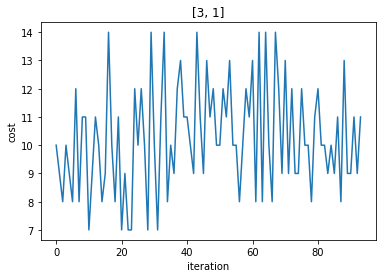

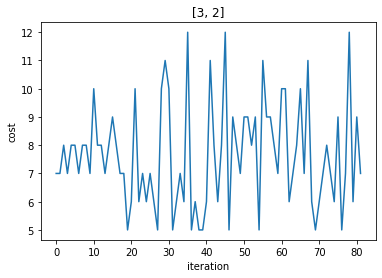

In [34]:
#draw graph
value_dict = {}
distinct_key = []
for i in test_cost_list:
  if i[0] not in distinct_key:
    distinct_key.append(i[0])
for i in distinct_key:
  value_dict[str(i)] = []
for i in test_cost_list:
  value_dict[str(i[0])].append(i[1])
for i in range(len(distinct_key)):
  draw_pic(range(len(value_dict[str(distinct_key[i])])), value_dict[str(distinct_key[i])], distinct_key[i], i)